# Portuguese Bank Marketing Project

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution.

The classification goal is to predict if the client will subscribe a term deposit (variable y). 

## Library Imports

In [1]:
#!pip install missingno
#!pip install xgboost
#!pip install hyperopt
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install warnings
#!pip install sklearn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import missingno as msno


from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, roc_auc_score, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Data Importing

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')

### Checking data

In [3]:
# View the first 5 rows in the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Input Variables:

#### Bank Client Data:
   1 - age (numeric)

   2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

   3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

   4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

   5 - default: has credit in default? (categorical: 'no','yes','unknown')

   6 - housing: has housing loan? (categorical: 'no','yes','unknown')
   
   7 - loan: has personal loan? (categorical: 'no','yes','unknown')
   
   #### Related with the last contact of the current campaign:
   
   8 - contact: contact communication type (categorical: 'cellular','telephone') 

   9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

  10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  
   #### Other attributes:
  
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

  14 - previous: number of contacts performed before this campaign and for this client (numeric)

  15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

   #### Social and Economic context attributes 
   
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     

  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     

  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  ### Output variable (desired target):
  
  21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

###  Separating into numeric and non - numeric columns

In [5]:
# select numerical columns
df_numeric = df.select_dtypes(include = [np.number])
numeric_cols = list(df_numeric.columns.values)
# select non-numeric columns
df_non_numeric = df.select_dtypes(exclude = [np.number])
non_numeric_cols = list(df_non_numeric.columns.values)

In [6]:
numeric_cols

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [7]:
non_numeric_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

### Check for missing values

<AxesSubplot: >

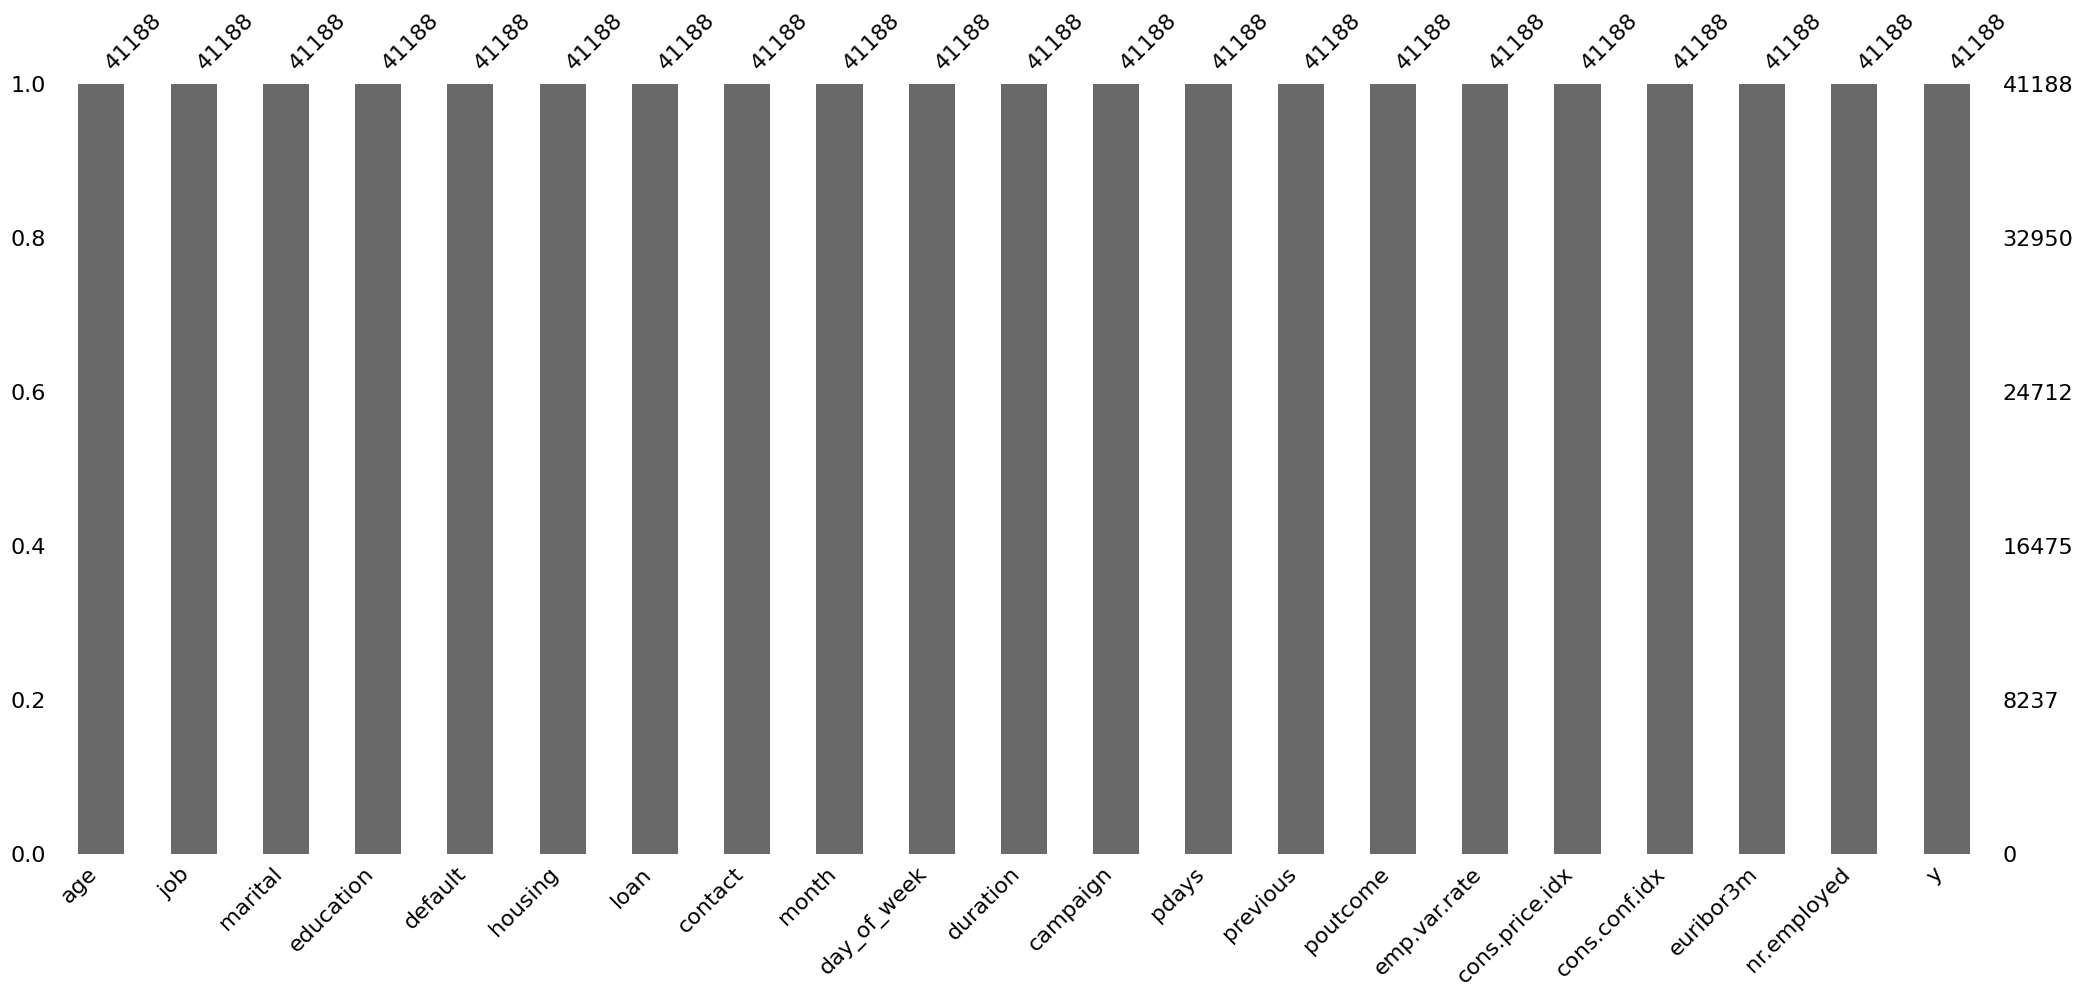

In [8]:
msno.bar(df)

### Remove duplicated rows (if any)

In [9]:
df.drop_duplicates(inplace = True)

### Validate the values of the data

In [10]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [11]:
for i in non_numeric_cols:
    print(i,": ", list(df[i].unique()))

job :  ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
marital :  ['married', 'single', 'divorced', 'unknown']
education :  ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
default :  ['no', 'unknown', 'yes']
housing :  ['no', 'yes', 'unknown']
loan :  ['no', 'yes', 'unknown']
contact :  ['telephone', 'cellular']
month :  ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
day_of_week :  ['mon', 'tue', 'wed', 'thu', 'fri']
poutcome :  ['nonexistent', 'failure', 'success']
y :  ['no', 'yes']


### Drop "Unknown" data value

In [12]:
df.replace(['unknown','Nan','NaN'], np.nan, inplace = True)
df.dropna(inplace = True)

In [13]:
for i in non_numeric_cols:
    print(i,": ", list(df[i].unique()))

job :  ['housemaid', 'services', 'admin.', 'technician', 'blue-collar', 'unemployed', 'retired', 'entrepreneur', 'management', 'student', 'self-employed']
marital :  ['married', 'single', 'divorced']
education :  ['basic.4y', 'high.school', 'basic.6y', 'professional.course', 'basic.9y', 'university.degree', 'illiterate']
default :  ['no', 'yes']
housing :  ['no', 'yes']
loan :  ['no', 'yes']
contact :  ['telephone', 'cellular']
month :  ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']
day_of_week :  ['mon', 'tue', 'wed', 'thu', 'fri']
poutcome :  ['nonexistent', 'failure', 'success']
y :  ['no', 'yes']


### Drop Outliers

In [14]:
#exclude pday and previous
var = list(set(numeric_cols) - set(['pdays','previous']))
summary = df[var].describe()
IQR = summary.iloc[6] - summary.iloc[4]
upperlimit = summary.iloc[6] + 1.5*IQR
lowerlimit = summary.iloc[4] - 1.5*IQR
df = df[~((df[var] < lowerlimit)|(df[var] > upperlimit)).any(axis=1)]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26008 entries, 0 to 41186
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             26008 non-null  int64  
 1   job             26008 non-null  object 
 2   marital         26008 non-null  object 
 3   education       26008 non-null  object 
 4   default         26008 non-null  object 
 5   housing         26008 non-null  object 
 6   loan            26008 non-null  object 
 7   contact         26008 non-null  object 
 8   month           26008 non-null  object 
 9   day_of_week     26008 non-null  object 
 10  duration        26008 non-null  int64  
 11  campaign        26008 non-null  int64  
 12  pdays           26008 non-null  int64  
 13  previous        26008 non-null  int64  
 14  poutcome        26008 non-null  object 
 15  emp.var.rate    26008 non-null  float64
 16  cons.price.idx  26008 non-null  float64
 17  cons.conf.idx   26008 non-null 

## EDA + Visualisation

In [16]:
print(df.describe())

                age      duration      campaign         pdays      previous  \
count  26008.000000  26008.000000  26008.000000  26008.000000  26008.000000   
mean      38.480852    207.566749      2.033990    958.833628      0.192941   
std        9.343437    140.718154      1.277686    195.638392      0.519317   
min       17.000000      0.000000      1.000000      0.000000      0.000000   
25%       31.000000    102.000000      1.000000    999.000000      0.000000   
50%       36.000000    171.000000      2.000000    999.000000      0.000000   
75%       45.000000    281.000000      3.000000    999.000000      0.000000   
max       66.000000    648.000000      6.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  26008.000000    26008.000000   26008.000000  26008.000000  26008.000000  
mean      -0.044921       93.528676     -40.803484      3.484327   5162.394444  
std        1.569679        0.573728       4.5

### Check the distribution of the target variable

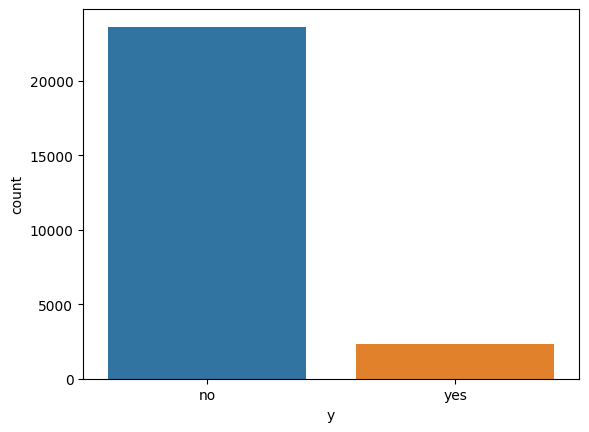

In [17]:
sns.countplot(x = 'y', data = df)
plt.show()

#### Countplot for the target variable 'y': 

The countplot shows that the dataset is imbalanced, with the number of 'no' values much higher than the number of 'yes' values. This indicates that the target variable is not equally distributed and we may need to use techniques such as oversampling or undersampling to balance the data before building a predictive model.

### Check the distribution of age

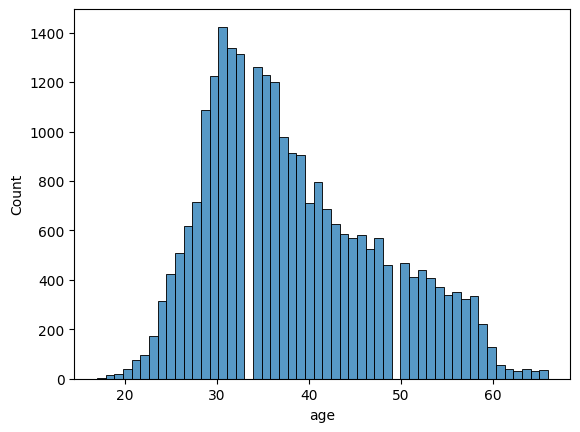

In [18]:
sns.histplot(x ='age', data = df, kde = False)
plt.show()

#### Histogram for age: 

The histogram shows that the distribution of age is roughly normal, with the majority of clients between 20-60 years old. This information can be helpful in identifying the age range that is most likely to respond positively to the marketing campaign.

### Check the distribution of job categories

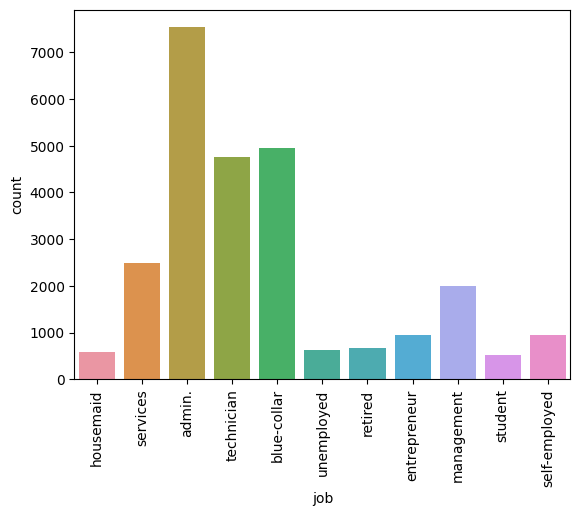

In [19]:
sns.countplot(x ='job', data = df)
plt.xticks(rotation = 90)
plt.show()

#### Countplot for job categories: 

The countplot shows that the most common job categories are 'admin.', 'blue-collar', and 'technician', while the least common categories are 'student', 'retired', 'housemaid', and 'unemployed'. This information can be helpful in understanding the demographics of the target audience and designing marketing strategies that cater to their needs and preferences.

### Check the distribution of education categories

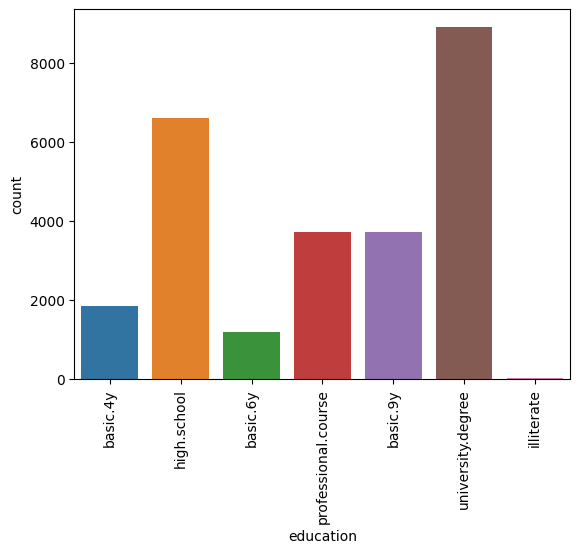

In [20]:
sns.countplot(x ='education', data = df)
plt.xticks(rotation = 90)
plt.show()

#### Countplot for education categories: 

The countplot shows that the most common education categories are 'university.degree', and 'high.school', while the least common categories are 'illiterate', 'basic.6y' and 'basic.4y'. This information can be helpful in understanding the educational background of the target audience and designing marketing strategies that are tailored to their level of education and knowledge.

### Check the correlation between numerical columns

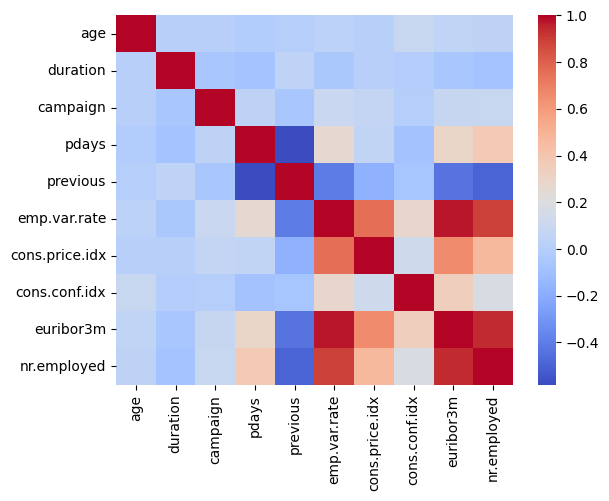

In [21]:
sns.heatmap(df[numeric_cols].corr(), cmap = 'coolwarm')
plt.show()

#### Heatmap for correlation between numerical columns:

The heatmap shows the correlation between numerical columns, where the darker shades of blue indicate stronger positive correlations and the darker shades of red indicate stronger negative correlations. The heatmap shows that the strongest positive correlation is between 'euribor3m' and 'emp.var.rate'. The strongest negative correlation is between 'duration' and 'campaign'. This information can be helpful in identifying the variables that have the strongest relationship with the target variable and can be used to build a more accurate predictive model.

## Data Preparation

### Train / Test split

In [22]:
X = df.drop('y', axis = 1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Tranform categorical data into dummy variables

In [23]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

### Standardisation

In [24]:
scale = StandardScaler()
X_train[var] = scale.fit_transform(X_train[var])
X_test[var] = scale.fit_transform(X_test[var])

### Dimensionality reduction

In [25]:
pca = PCA(n_components = 10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## Classification

### Logistic Regression

#### Fitting the model without changing any parameters

In [26]:
# instantiate the logistic regression model
logreg = LogisticRegression(max_iter=1000)

# fit the model on the training data
logreg.fit(X_train, y_train)

# make predictions on the test data
y_pred_log_n = logreg.predict(X_test)

# evaluate the model performance on the test data
accuracy_log = accuracy_score(y_test, y_pred_log_n)
print("Accuracy: ", accuracy_log)
print("Classification Report: ")
print(classification_report(y_pred_log_n, y_test))

Accuracy:  0.932718185313341
Classification Report: 
              precision    recall  f1-score   support

          no       0.98      0.95      0.96      7335
         yes       0.46      0.66      0.54       468

    accuracy                           0.93      7803
   macro avg       0.72      0.81      0.75      7803
weighted avg       0.95      0.93      0.94      7803



The default value of max_iter parameter in scikit-learn's logistic regression model is 100. However, this is not enough for the algorithm to converge. Therefore, it is increased to 1000.

##### Precision: 
In this report, the precision for the "no" class is 0.98, meaning that of all the samples predicted as "no", 98% were actually "no". The precision for the "yes" class is 0.46, meaning that of all the samples predicted as "yes", only 46% were actually "yes".

##### Recall: 
In this report, the recall for the "no" class is 0.95, meaning that of all the actual "no" samples, the classifier correctly identified 95% as "no". The recall for the "yes" class is 0.66, meaning that of all the actual "yes" samples, the classifier correctly identified 66% as "yes".

##### F1-score: 
In this report, the F1-score for the "no" class is 0.96, while the F1-score for the "yes" class is 0.54.

##### Support: 
The support is the number of samples in each class.

##### Accuracy: 
The overall accuracy of the model is 0.93, which means that the model correctly predicted the class label for 93% of the samples.

#### Hyperparameter Tuning Using GridSearchCV

In [27]:
# Logistic regression with regularization
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Create a logistic regression model
logreg = LogisticRegression(solver ='saga', max_iter = 10000)

# Create a grid search object
grid_search = GridSearchCV(logreg, param_grid = param_grid, cv = 5, n_jobs = -1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'C': 10, 'penalty': 'l2'}


In [28]:
# instantiate the logistic regression model
logreg = LogisticRegression(solver = 'saga', max_iter = 10000, C = 10, penalty = 'l2')

# fit the model on the training data
logreg.fit(X_train, y_train)

# make predictions on the test data
y_pred_log = logreg.predict(X_test)

# evaluate the model performance on the test data
accuracy_log = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy_log)
print("Classification Report: ")
print(classification_report(y_pred_log, y_test))

Accuracy: 0.9313084711008587
Classification Report: 
              precision    recall  f1-score   support

          no       0.98      0.95      0.96      7348
         yes       0.44      0.65      0.53       455

    accuracy                           0.93      7803
   macro avg       0.71      0.80      0.74      7803
weighted avg       0.95      0.93      0.94      7803



##### Precision: 
In this report, the precision for the "no" class is 0.98, meaning that of all the samples predicted as "no", 98% were actually "no". The precision for the "yes" class is 0.44, meaning that of all the samples predicted as "yes", only 44% were actually "yes".

##### Recall: 
In this report, the recall for the "no" class is 0.95, meaning that of all the actual "no" samples, the classifier correctly identified 95% as "no". The recall for the "yes" class is 0.65, meaning that of all the actual "yes" samples, the classifier correctly identified 65% as "yes".

##### F1-score: 
In this report, the F1-score for the "no" class is 0.96, while the F1-score for the "yes" class is 0.53.

##### Support: 
The support is the number of samples in each class.

##### Accuracy: 
The overall accuracy of the model is 0.93, which means that the model correctly predicted the class label for 93% of the samples.

#### Conclusion

Just use normal logistic regression, no optimization !

### KNN

#### Fitting the model withouth tweaking any parameters

In [29]:
# instantiate the K Nearest Neighbors model
knn = KNeighborsClassifier()

# fit the model on the training data
knn.fit(X_train,y_train)

# make predictions on the test data
pred_knn = knn.predict(X_test)

# evaluate the model performance on the test data
accuracy_knn = accuracy_score(pred_knn,y_test)
print("Accuracy: ",accuracy_knn)
print("Classification Report: ")
print(classification_report(pred_knn, y_test))

Accuracy:  0.9261822376009228
Classification Report: 
              precision    recall  f1-score   support

          no       0.97      0.95      0.96      7310
         yes       0.44      0.60      0.51       493

    accuracy                           0.93      7803
   macro avg       0.71      0.78      0.73      7803
weighted avg       0.94      0.93      0.93      7803



##### Precision: 
In this report, the precision for the "no" class is 0.97, meaning that of all the samples predicted as "no", 97% were actually "no". The precision for the "yes" class is 0.44, meaning that of all the samples predicted as "yes", only 44% were actually "yes".

##### Recall: 
In this report, the recall for the "no" class is 0.95, meaning that of all the actual "no" samples, the classifier correctly identified 95% as "no". The recall for the "yes" class is 0.60, meaning that of all the actual "yes" samples, the classifier correctly identified 60% as "yes".

##### F1-score: 
In this report, the F1-score for the "no" class is 0.96, while the F1-score for the "yes" class is 0.51.

##### Support: 
The support is the number of samples in each class.

##### Accuracy: 
The overall accuracy of the model is 0.93, which means that the model correctly predicted the class label for 93% of the samples.

##### Macro-average: 
In this report, the macro-average for precision, recall, and F1-score are 0.71, 0.78, and 0.73 respectively.

##### Weighted-average: 
In this report, the weighted-average for precision, recall, and F1-score are 0.94, 0.93, and 0.93 respectively.

###### One of the challenges in a KNN algorithm is finding the best 'k' i.e. the number of neighbors to be used in the majority vote while deciding the class. Generally, it is advisable to test the accuracy of your model for different values of k and then select the best one from them.

#### Finding suitable range for nearest neighbor parameter

In [30]:
# calculating the accuracy of models with different values of k
mean_acc = np.zeros(30)

#Train Model and Predict for neighbors from 1 till 30
for i in range(1,31):     
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    pred_knn = knn.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, pred_knn)

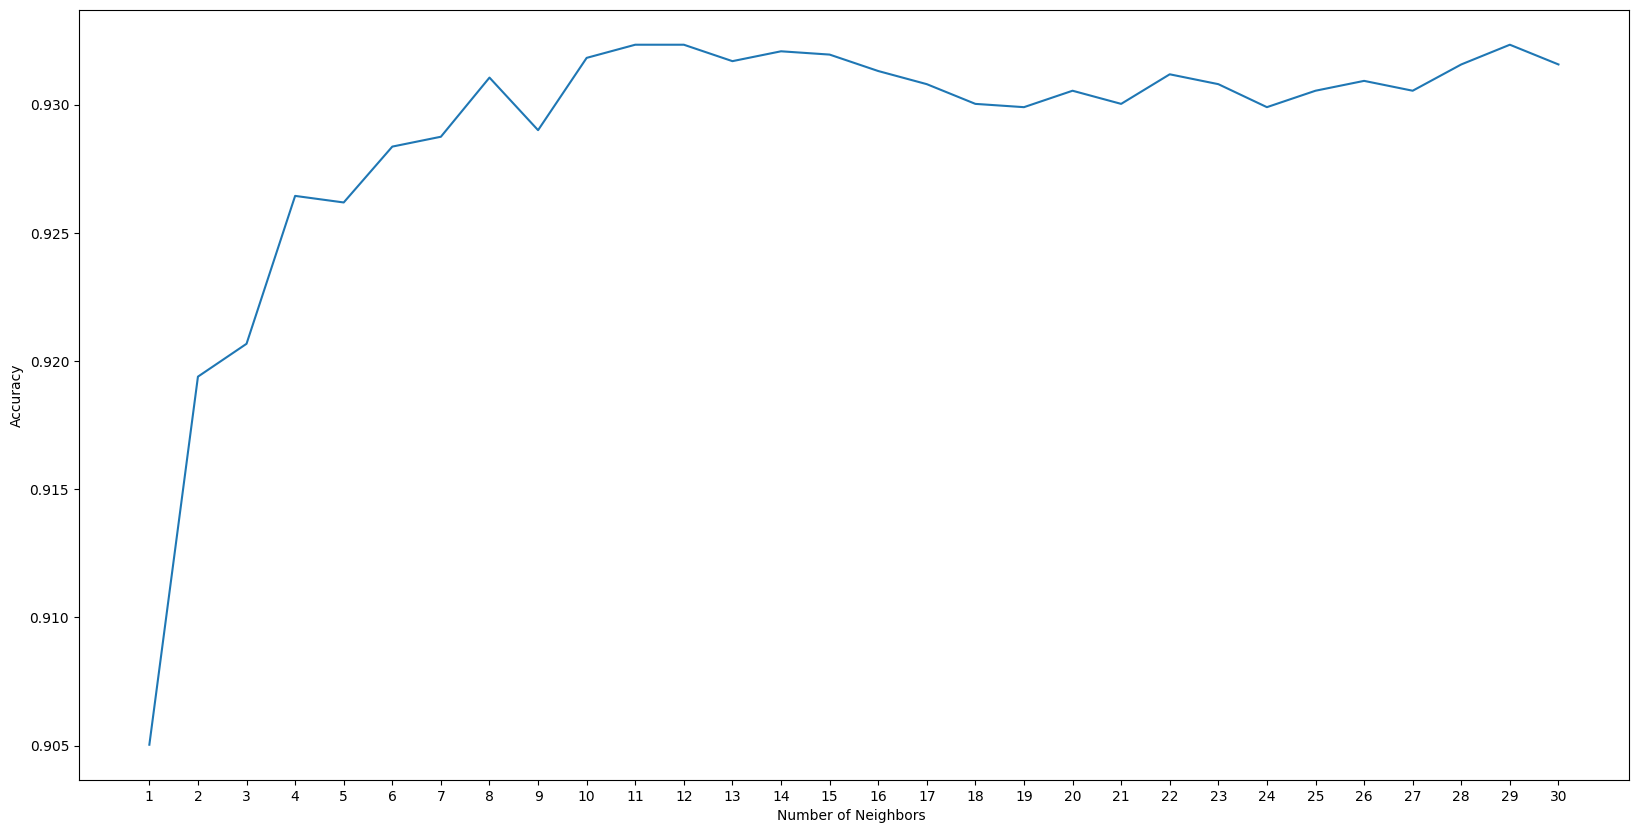

In [31]:
loc = np.arange(1,31,step = 1.0)
plt.figure(figsize = (20, 10))
plt.plot(range(1,31), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

##### There are a range of values from 11 to 23 where the accuracy is the highest. Hence we take those values for hyperparamter tuning

#### Hyperparameter Tuning Using GridSearchCV

In [32]:
# Define the parameter grid
grid_params = { 'n_neighbors' : [i for i in range(11,24,2)],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

# Create a grid search object
grid_search = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)

# fit the model on our train set
grid_search_result = grid_search.fit(X_train, y_train)

# find the best score
grid_search_result.best_score_

# get the hyperparameters with the best score
grid_search_result.best_params_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


{'metric': 'minkowski', 'n_neighbors': 21, 'weights': 'distance'}

Training set accuracy:  1.0
Test set accuracy:  0.9297706010508778


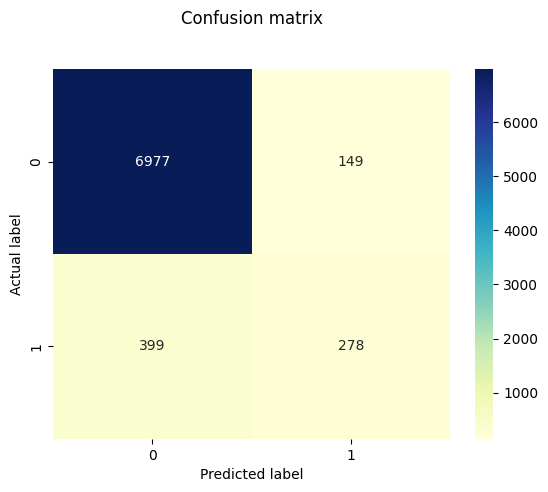

Accuracy:  0.9297706010508778
Classification Report: 
              precision    recall  f1-score   support

          no       0.95      0.98      0.96      7126
         yes       0.65      0.41      0.50       677

    accuracy                           0.93      7803
   macro avg       0.80      0.69      0.73      7803
weighted avg       0.92      0.93      0.92      7803



In [33]:
# Use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 21, weights = 'distance',algorithm = 'brute',metric = 'minkowski')
knn.fit(X_train, y_train)

# get a prediction
pred_knn = knn.predict(X_train)
y_knn = knn.predict(X_test)

# get train set and test set accuracy
print('Training set accuracy: ', metrics.accuracy_score(y_train, pred_knn))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_knn))

# make a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_knn)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# make a classification report
accuracy_knn = accuracy_score(y_knn,y_test)
print("Accuracy: ",accuracy_knn)
print("Classification Report: ")
print(classification_report(y_test, y_knn))

##### Precision:
For the 'yes' class, the precision is 0.65, which means that out of all the instances predicted as 'yes', only 65% of them are actually 'yes'. For the 'no' class, the precision is 0.95, which means that out of all the instances predicted as 'no', 95% of them are actually 'no'. 

##### Recall:
The recall is 0.41, which means that out of all the actual 'yes' instances, only 41% of them are correctly identified as 'yes'. The recall is 0.98, which means that out of all the actual 'no' instances, 98% of them are correctly identified as 'no'. 


##### F1 Score:
The F1-score, which is the harmonic mean of precision and recall, is 0.96. There are 7126 instances of the 'no' class in the test set. The F1-score is 0.50. There are 667 instances of the 'yes' class in the test set.

##### Accuracy:
The overall accuracy of the model is 0.93, which means that 93% of the instances in the test set were correctly classified by the model.


##### Macro Average
The macro average of the metrics is the average of precision, recall, and F1-score for both classes, and it is 0.80 for precision, 0.69 for recall, and 0.73 for F1-score. 

##### Weighted Average
The weighted average is the average of the metrics weighted by the number of instances in each class, and it is 0.92 for precision, 0.93 for recall, and 0.92 for F1-score.

#### Regularizing

In [34]:
# define the y data in numeric form
y_train_new = y_train.map({'yes':1,'no':0})
y_test_new = y_test.map({'yes':1,'no':0})

# create a pipeline with the Lasso and Ridge model and the StandardScaler
alpha = [0.0000001,0.00001,0.0001,0.001,0.01,0.1,1]
for i in alpha:
    model_lasso = make_pipeline(
        StandardScaler(),
        Lasso(alpha = i, tol = 0.0001)
    )
    model_ridge = make_pipeline(
        StandardScaler(),
        Ridge(alpha = i, tol = 0.0001)
    )

    # fit the model to the training data
    model_lasso.fit(X_train, y_train_new)
    model_ridge.fit(X_train, y_train_new)

    # make predictions on the training and test data
    y_train_pred_lasso = model_lasso.predict(X_train)
    y_test_pred_lasso = model_lasso.predict(X_test)
    y_train_pred_ridge = model_ridge.predict(X_train)
    y_test_pred_ridge = model_ridge.predict(X_test)

    
    # evaluate the performance of the model
    print(f'Training R2 for Lasso for alpha {i} :', r2_score(y_train_new, y_train_pred_lasso))
    print(f'Test R2 for Lasso for alpha {i} :', r2_score(y_test_new, y_test_pred_lasso))
    print(f'Training R2 for Ridge for alpha {i} :', r2_score(y_train_new, y_train_pred_ridge))
    print(f'Test R2 for Ridge for alpha {i} :', r2_score(y_test_new, y_test_pred_ridge))
    print()

Training R2 for Lasso for alpha 1e-07 : 0.3489814616447118
Test R2 for Lasso for alpha 1e-07 : 0.34549566751790683
Training R2 for Ridge for alpha 1e-07 : 0.34898164790992137
Test R2 for Ridge for alpha 1e-07 : 0.34548933131331316

Training R2 for Lasso for alpha 1e-05 : 0.34897913335945474
Test R2 for Lasso for alpha 1e-05 : 0.34550543760937225
Training R2 for Ridge for alpha 1e-05 : 0.34898164790992126
Test R2 for Ridge for alpha 1e-05 : 0.34548933136836424

Training R2 for Lasso for alpha 0.0001 : 0.3488465056524803
Test R2 for Lasso for alpha 0.0001 : 0.34545830443689185
Training R2 for Ridge for alpha 0.0001 : 0.3489816479099036
Test R2 for Ridge for alpha 0.0001 : 0.34548933186881037

Training R2 for Lasso for alpha 0.001 : 0.34418463728808546
Test R2 for Lasso for alpha 0.001 : 0.3417403212791851
Training R2 for Ridge for alpha 0.001 : 0.34898164790813124
Test R2 for Ridge for alpha 0.001 : 0.34548933687146877

Training R2 for Lasso for alpha 0.01 : 0.3278617677650312
Test R2 fo

##### Why Regularizing is not working ?

L1 and L2 regularization are typically used in linear models such as linear regression and logistic regression to prevent overfitting by adding a penalty to the coefficients. However, KNN is a non-parametric model, meaning it does not have coefficients that can be penalized.

Therefore, applying L1 or L2 regularization to KNN is not appropriate and may not have any effect on the model's performance. It's possible that regularization is introducing bias into the model, resulting in reduced performance. In general, KNN is not known for its interpretability and may not benefit from regularization in the same way as linear models.

#### Conclusion

SO EARLIER THE ACCURACY WAS 0.926182 AND AFTER HYPERPARAMETER TUNING, THE ACCURACY IS 0.929771. HENCE IT WOULDN'T BE WISE TO DO HYPER PARAMETER TUNING FOR KNN MODEL AND INSTEAD RUN THE CLASSIFIER AS IT IS.

### Random Forest

#### Fitting the model withouth tweaking any parameters

In [35]:
# instantiate the Random Forest model
rfc = RandomForestClassifier()

# fit the model on the training data
rfc.fit(X_train, y_train)

# make predictions on the test data
pred_rfc = rfc.predict(X_test)

# evaluate the model performance on the test data
accuracy_rfc = accuracy_score(pred_rfc, y_test)
print("Accuracy: ",accuracy_rfc)
print("Classification Report: ")
print(classification_report(pred_rfc, y_test))

Accuracy:  0.9316929386133539
Classification Report: 
              precision    recall  f1-score   support

          no       0.98      0.95      0.96      7331
         yes       0.45      0.65      0.54       472

    accuracy                           0.93      7803
   macro avg       0.72      0.80      0.75      7803
weighted avg       0.95      0.93      0.94      7803



##### Precision: 
In this report, the precision for the "no" class is 0.98, which means that 98% of the instances predicted as "no" are actually "no". The precision for the "yes" class is 0.46, which means that only 46% of the instances predicted as "yes" are actually "yes".

##### Recall: 
In this report, the recall for the "no" class is 0.95, which means that 95% of the actual "no" instances are correctly predicted as "no". The recall for the "yes" class is 0.66, which means that 66% of the actual "yes" instances are correctly predicted as "yes".

##### F1-score: 
In this report, the F1-score for the "no" class is 0.96, which means that the model has a good balance of precision and recall for the "no" class. The F1-score for the "yes" class is 0.54, which indicates that the model's performance for the "yes" class is not as good as for the "no" class.

##### Support: 
In this report, there are 7333 instances of the "no" class and 470 instances of the "yes" class.

##### Accuracy: 
In this report, the overall accuracy of the model is 0.93, which means that 93% of the instances are correctly classified by the model.

##### Macro-avg: 
In this report, the macro-averaged precision, recall, and F1-score are 0.72, 0.81, and 0.75, respectively.

##### Weighted-avg:
In this report, the weighted-averaged precision, recall, and F1-score are 0.95, 0.93, and 0.94, respectively.

#### Hyperparameter Tuning Using RandomizedSearchCV

RandomizedSearchCV is preferred over GridSearchCV when the search space of hyperparameters is large because it can explore a wider range of hyperparameters with a limited computational budget.

With RandomizedSearchCV, we can specify the number of iterations to run, and it will randomly sample the hyperparameter space for each iteration. This means that RandomizedSearchCV can efficiently find good hyperparameters in a large search space without the computational overhead of GridSearchCV, which exhaustively searches the entire hyperparameter space.

Additionally, RandomizedSearchCV may be more effective in finding better hyperparameters because it can explore regions of the hyperparameter space that GridSearchCV may not visit due to its exhaustive search pattern.

In [50]:
# Define the parameter grid
random_grid = {'n_estimators': [5,10,25,50,75,100],
               'criterion':["gini", "entropy", "log_loss"],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
               'min_samples_split': [2, 6, 10],
               'min_samples_leaf': [1, 3, 4],
               'bootstrap': [True, False]}

# Create a grid search object
rfc = RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator = rfc,param_distributions = random_grid,n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

# fit the model on our train set
rfc_random.fit(X_train, y_train)

# get the hyperparameters with the best score
print ('Best Parameters: ', rfc_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 75, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'entropy', 'bootstrap': True}  



Training set accuracy:  0.956001098599286
Test set accuracy:  0.9361783929257977


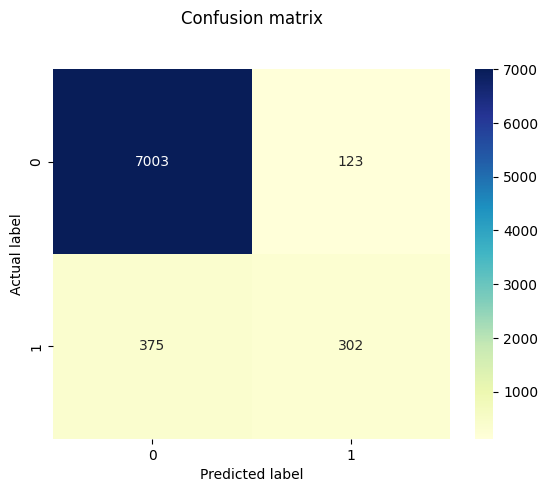

Accuracy:  0.9361783929257977
Classification Report: 
              precision    recall  f1-score   support

          no       0.95      0.98      0.97      7126
         yes       0.71      0.45      0.55       677

    accuracy                           0.94      7803
   macro avg       0.83      0.71      0.76      7803
weighted avg       0.93      0.94      0.93      7803



In [51]:
# Use the best hyperparameters
rf = RandomForestClassifier(n_estimators = rfc_random.best_params_['n_estimators'], 
                            min_samples_split = rfc_random.best_params_['min_samples_split'], 
                            min_samples_leaf = rfc_random.best_params_['min_samples_leaf'],
                            max_features = rfc_random.best_params_['max_features'], 
                            max_depth = rfc_random.best_params_['max_depth'], 
                            criterion = rfc_random.best_params_['criterion'], 
                            bootstrap = rfc_random.best_params_['bootstrap'])
rf.fit( X_train, y_train) 

# get a prediction
pred_rf = rf.predict(X_train)
y_rf = rf.predict(X_test)

# get train set and test set accuracy
print('Training set accuracy: ', metrics.accuracy_score(y_train, pred_rf))
print('Test set accuracy: ',metrics.accuracy_score(y_test, y_rf))

# make a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_rf)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# make a classification report
accuracy_rf = accuracy_score(y_rf,y_test)
print("Accuracy: ",accuracy_rf)
print("Classification Report: ")
print(classification_report(y_test, y_rf))

##### Precision: 
In this report, the precision for the "no" class is 0.95, which means that 95% of the predicted "no" labels were correct. The precision for the "yes" class is 0.70, which means that 70% of the predicted "yes" labels were correct.

##### Recall: 
In this report, the recall for the "no" class is 0.98, which means that 98% of the actual "no" labels were correctly predicted. The recall for the "yes" class is 0.44, which means that only 44% of the actual "yes" labels were correctly predicted.

##### F1-score: 
In this report, the F1-score for the "no" class is 0.97, and the F1-score for the "yes" class is 0.54.

##### Support: 
In this report, there are 7126 instances of the "no" class and 677 instances of the "yes" class.

##### Accuracy: 
In this report, the overall accuracy is 0.94, which means that 93% of the predictions were correct.

##### Macro average: 
In this report, the macro average precision is 0.83, the macro average recall is 0.71, and the macro average F1-score is 0.75.

##### Weighted average: 
In this report, the weighted average precision is 0.93, the weighted average recall is 0.94, and the weighted average F1-score is 0.93.

#### Conclusion

SO EARLIER THE ACCURACY WAS 0.932974 AND AFTER HYPERPARAMETER TUNING, THE ACCURACY IS 0.935409. HENCE IT WOULDN'T BE WISE TO DO HYPER PARAMETER TUNING FOR RANDOM FOREST MODEL AND INSTEAD RUN THE CLASSIFIER AS IT IS.

### XGBoost

####  Changing target data in numeric form

In [38]:
y_train_xgb = y_train.map({'yes':1,'no':0})
y_test_xgb = y_test.map({'yes':1,'no':0})

#### Fitting the model withouth changing any parameters

In [39]:
# instantiate the XGBoost model
xgb = XGBClassifier()

# fit the model on the training data
xgb.fit(X_train, y_train_xgb)

# make predictions on the test data
pred_xgb = xgb.predict(X_test)

# evaluate the model performance on the test data
accuracy_xgb = accuracy_score(pred_xgb, y_test_xgb)
print("Accuracy: ",accuracy_xgb)
print("Classification Report: ")
print(classification_report(pred_xgb, y_test_xgb))

Accuracy:  0.9209278482634884
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7165
           1       0.52      0.55      0.53       638

    accuracy                           0.92      7803
   macro avg       0.74      0.75      0.74      7803
weighted avg       0.92      0.92      0.92      7803



#### Hyperparameter Tuning Using Bayesian Optimization with HYPEROPT

A popular alternative to tune the model hyperparameters is Bayesian Optimization. Bayesian Optimization is a probabilistic model-based technique used to find minimum of any function. This approach can yield better performance on the test set while it requires fewer iterations than random search. It takes into account past evaluations when choosing the optimal set of hyperparameters. Thus it chooses its parameter combinations in an informed way. In doing so, it focus on those parameters that yield the best possible scores. Thus, this technique requires less number of iterations to find the optimal set of parameter values. It ignores those areas of the parameter space that are useless. Hence, it is less time-consuming and not frustrating at all.

In [40]:
# Define the parameter grid
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0}

# Define the objective function
def objective(space):
    clf=XGBClassifier(n_estimators =space['n_estimators'], 
                      max_depth = int(space['max_depth']), 
                      gamma = space['gamma'],
                      reg_alpha = int(space['reg_alpha']),
                      min_child_weight=int(space['min_child_weight']),
                      colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train_xgb), ( X_test, y_test_xgb)]
    clf.fit(X_train, y_train_xgb,eval_set=evaluation, eval_metric="auc",early_stopping_rounds=10,verbose=False)
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test_xgb, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# Run the optimization algorithm
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# get the best hyperparameters
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                                                                                 
0.9279764193259002                                                                                                     
SCORE:                                                                                                                 
0.9282327310008971                                                                                                     
SCORE:                                                                                                                 
0.9242599000384467                                                                                                     
SCORE:                                                                                                                 
0.9173394848135332                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.9250288350634371                                                                                                     
SCORE:                                                                                                                 
0.9274637959759067                                                                                                     
SCORE:                                                                                                                 
0.9284890426758939                                                                                                     
SCORE:                                                                                                                 
0.925285146738434                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
0.9278482634884019                                                                                                     
SCORE:                                                                                                                 
0.928873510188389                                                                                                      
SCORE:                                                                                                                 
0.9268230167884147                                                                                                     
SCORE:                                                                                                                 
0.9241317442009483                                                                                                     
SCORE:                                  

Training set accuracy:  0.9338643229881901
Test set accuracy:  0.9356657695758042


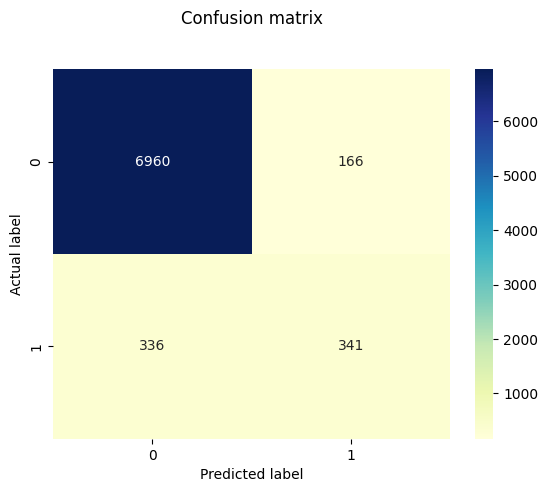

Accuracy:  0.9356657695758042
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7126
           1       0.67      0.50      0.58       677

    accuracy                           0.94      7803
   macro avg       0.81      0.74      0.77      7803
weighted avg       0.93      0.94      0.93      7803



In [41]:
# Use the best hyperparameters
xgb = XGBClassifier(colsample_bytree = best_hyperparams['colsample_bytree'], 
                    gamma = best_hyperparams['gamma'], 
                    max_depth = int(best_hyperparams['max_depth']), 
                    min_child_weight = best_hyperparams['min_child_weight'], 
                    reg_alpha = best_hyperparams['reg_alpha'], 
                    reg_lambda = best_hyperparams['reg_lambda'])
xgb.fit(X_train, y_train_xgb)

# get a prediction
pred_xgb = xgb.predict(X_train)
y_xgb = xgb.predict(X_test)

# get train set and test set accuracy
print('Training set accuracy: ', metrics.accuracy_score(y_train_xgb, pred_xgb))
print('Test set accuracy: ',metrics.accuracy_score(y_test_xgb, y_xgb))

# make a confusion matrix
cnf_matrix = confusion_matrix(y_test_xgb, y_xgb)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# make a classification report
accuracy_xgb = accuracy_score(y_xgb,y_test_xgb)
print("Accuracy: ",accuracy_xgb)
print("Classification Report: ")
print(classification_report(y_test_xgb, y_xgb))

##### Precision: 
The precision for the "0" class (no) is 0.95, which means that out of all the predictions made for the "0" class, 95% of them were correct. The precision for the "1" class (yes) is 0.67, which means that out of all the predictions made for the "1" class, 67% of them were correct.

##### Recall: 
The recall for the "0" class is 0.98, which means that out of all the actual "0" class instances, 98% were correctly predicted by the model. The recall for the "1" class is 0.48, which means that out of all the actual "1" class instances, only 48% were correctly predicted by the model.

##### F1-score: 
The F1-score is the harmonic mean of precision and recall. The F1-score for the "0" class is 0.96, and the F1-score for the "1" class is 0.56.

##### Support: 
The support column shows the number of samples in each class. There are 7126 samples in the "0" class and 677 samples in the "1" class.

##### Accuracy: 
The accuracy of the model is 0.93, which means that 93% of the predictions made by the model were correct.

##### Macro avg: 
The macro-average precision, recall, and F1-score are 0.81, 0.73, and 0.76, respectively.

##### Weighted avg: 
The weighted-average precision, recall, and F1-score are 0.93, 0.93, and 0.93, respectively.

#### Conclusion

SO EARLIER THE ACCURACY WAS 0.920928 AND AFTER HYPERPARAMETER TUNING, THE ACCURACY IS 0.934769. HENCE IT WOULDN'T BE WISE TO DO HYPER PARAMETER TUNING FOR XGBOOST MODEL AND INSTEAD RUN THE CLASSIFIER AS IT IS.

## Selecting the best model

### Making an accuracy score table

In [52]:
acc_table = pd.DataFrame({'Model': ['Logistic Regression',
                                   'KNN',
                                   'Random Forest Tree',
                                   'XGB'],
                         'Accuracy Score': [accuracy_log,
                                           accuracy_knn,
                                           accuracy_rf,
                                           accuracy_xgb]})
acc_table = acc_table.sort_values(by = 'Accuracy Score', ascending = False)
acc_table.style.background_gradient(cmap = 'Blues')

,Model,Accuracy Score
2,Random Forest Tree,0.936178
3,XGB,0.935666
0,Logistic Regression,0.931308
1,KNN,0.929771


### Making a ROC curve for the best model

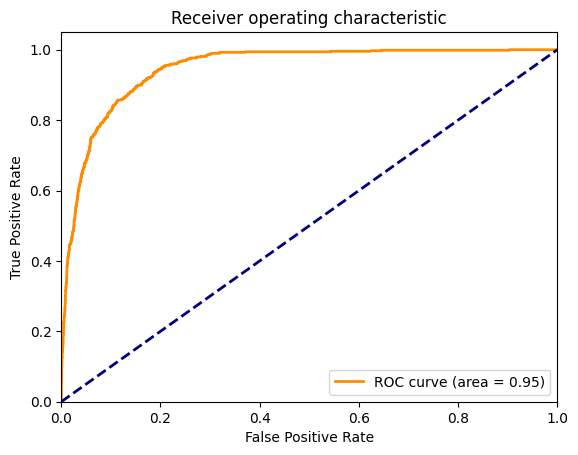

In [53]:
y_test_rf = y_test.map({'yes':1,'no':0})
y_pred_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_rf, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.show()

A value of 0.95 means that the classifier has a high level of accuracy in distinguishing between the positive and negative classes. In other words, a value of 0.95 indicates that the model is able to correctly identify 95% of true positives while also minimizing the number of false positives. A high value for the ROC curve is generally desirable as it indicates that the model is performing well.

## Feature Importance

### See the most important features

Text(0, 0.5, 'Importance')

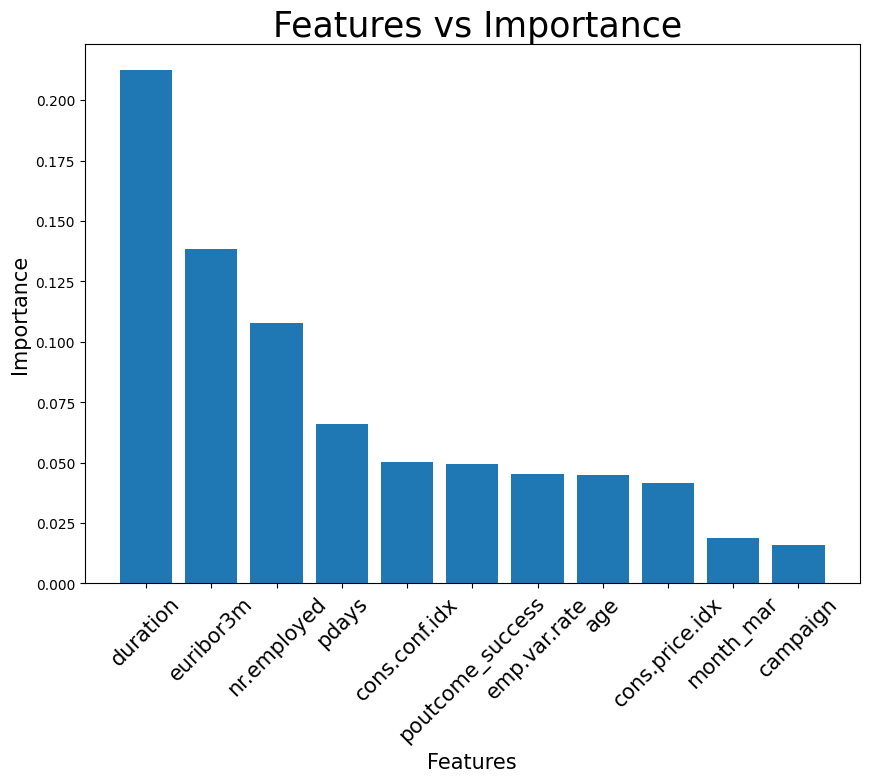

In [44]:
# list all features and their importances
features = list(rf.feature_importances_)
X_cols = list(X_train.columns)

# convert it into a dataframe and sort it in descending order to get the top 11 features
feature_importance = pd.DataFrame(features,index = X_cols,columns = ['importance'])
feature_importance.sort_values('importance',ascending = False,inplace = True)
feature_importance = feature_importance.iloc[:11,]

# plot a bar chart of features vs importance
fig = plt.figure(1, [10,7])
plt.bar(feature_importance.index, feature_importance['importance'])
plt.title(' Features vs Importance', fontsize = 25)
plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 10)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Importance', fontsize = 15)

### How accuracy changes with top k number of features for the best model (Random Forest)

In [45]:
accuracy = []
for j in range(1,len(features)+1):
    features = list(rf.feature_importances_)
    X_cols = list(X_train.columns)
    imp_cols = []
    
    # get the top important features
    for i in range(j):
        index = features.index(max(features))
        imp_cols.append(X_cols[index])
        X_cols.pop(index)
        features.pop(index)
    
    # create new dataset based on important features
    X_train_new = X_train[imp_cols].copy()
    X_test_new = X_test[imp_cols].copy()
    
    #instantiate and fit the model
    rf_new = RandomForestClassifier()
    rf_new.fit(X_train_new, y_train) 

    # get a prediction
    y_rf = rf_new.predict(X_test_new)
    print(f'Test set accuracy with top {j} important features : ',metrics.accuracy_score(y_test, y_rf))
    print(f"Important features are {imp_cols}")
    print()
    accuracy.append(metrics.accuracy_score(y_test, y_rf))

Test set accuracy with top 1 important features :  0.907599641163655
Important features are ['duration']

Test set accuracy with top 2 important features :  0.892477252338844
Important features are ['duration', 'euribor3m']

Test set accuracy with top 3 important features :  0.908881199538639
Important features are ['duration', 'euribor3m', 'nr.employed']

Test set accuracy with top 4 important features :  0.9138792772010765
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays']

Test set accuracy with top 5 important features :  0.9134948096885813
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx']

Test set accuracy with top 6 important features :  0.9124695629885942
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx', 'poutcome_success']

Test set accuracy with top 7 important features :  0.9129821863385877
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.i

Test set accuracy with top 28 important features :  0.9311803152633602
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx', 'poutcome_success', 'emp.var.rate', 'age', 'cons.price.idx', 'month_mar', 'campaign', 'previous', 'month_may', 'poutcome_failure', 'month_oct', 'poutcome_nonexistent', 'education_university.degree', 'day_of_week_mon', 'contact_cellular', 'month_jun', 'contact_telephone', 'day_of_week_fri', 'job_admin.', 'marital_married', 'housing_no', 'day_of_week_thu', 'marital_single', 'housing_yes']

Test set accuracy with top 29 important features :  0.9311803152633602
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx', 'poutcome_success', 'emp.var.rate', 'age', 'cons.price.idx', 'month_mar', 'campaign', 'previous', 'month_may', 'poutcome_failure', 'month_oct', 'poutcome_nonexistent', 'education_university.degree', 'day_of_week_mon', 'contact_cellular', 'month_jun', 'contact_telephone', 'day_of_week_fr

Test set accuracy with top 41 important features :  0.9336152761758298
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx', 'poutcome_success', 'emp.var.rate', 'age', 'cons.price.idx', 'month_mar', 'campaign', 'previous', 'month_may', 'poutcome_failure', 'month_oct', 'poutcome_nonexistent', 'education_university.degree', 'day_of_week_mon', 'contact_cellular', 'month_jun', 'contact_telephone', 'day_of_week_fri', 'job_admin.', 'marital_married', 'housing_no', 'day_of_week_thu', 'marital_single', 'housing_yes', 'education_high.school', 'month_sep', 'day_of_week_wed', 'job_technician', 'day_of_week_tue', 'month_apr', 'education_professional.course', 'loan_no', 'job_blue-collar', 'job_student', 'loan_yes', 'education_basic.9y', 'month_aug']

Test set accuracy with top 42 important features :  0.9322055619633475
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx', 'poutcome_success', 'emp.var.rate', 'age', 'cons.price.

Test set accuracy with top 51 important features :  0.9316929386133539
Important features are ['duration', 'euribor3m', 'nr.employed', 'pdays', 'cons.conf.idx', 'poutcome_success', 'emp.var.rate', 'age', 'cons.price.idx', 'month_mar', 'campaign', 'previous', 'month_may', 'poutcome_failure', 'month_oct', 'poutcome_nonexistent', 'education_university.degree', 'day_of_week_mon', 'contact_cellular', 'month_jun', 'contact_telephone', 'day_of_week_fri', 'job_admin.', 'marital_married', 'housing_no', 'day_of_week_thu', 'marital_single', 'housing_yes', 'education_high.school', 'month_sep', 'day_of_week_wed', 'job_technician', 'day_of_week_tue', 'month_apr', 'education_professional.course', 'loan_no', 'job_blue-collar', 'job_student', 'loan_yes', 'education_basic.9y', 'month_aug', 'marital_divorced', 'job_retired', 'job_services', 'job_management', 'job_self-employed', 'month_nov', 'month_jul', 'education_basic.4y', 'education_basic.6y', 'job_unemployed']

Test set accuracy with top 52 importan

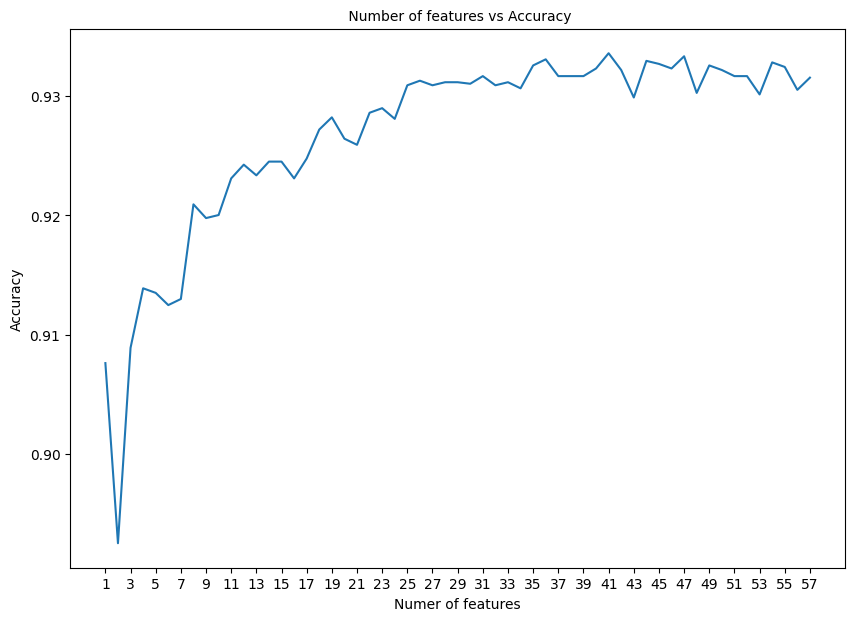

In [46]:
# plot number of important features vs accuracy
no_of_features = [i for i in range(1,len(accuracy)+1)]
fig = plt.figure(1, [10,7])
plt.title(' Number of features vs Accuracy', fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks(no_of_features[::2])
plt.xlabel('Numer of features', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.plot(no_of_features,accuracy)

## Conclusion

- A bank wants to know whether clients will subscribe a term deposit or not; so that they need information about the correlation between the variables given in the dataset.

- The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

- According to previous analysis, a target customer profile can be established. The most responsive customers possess these features:

    * Feature 1: age > 20 or age < 60
    
    * Feature 2: admin, blue-collar or technician
    
    * Feature 3: university degree or high school
    

- Here we used 4 classification models to study.

- From the accuracy scores , it seems like "Random Forest" algorithm have the highest accuracy and stability.

- But we can use other models also as they too have a similar accuracy and stability.

- In addition, predicting duration before calling and adjusting marketing plan benefit both the bank and its clients. On the one hand, it will increase the efficiency of the bank’s telemarketing campaign, saving time and efforts. On the other hand, it prevents some clients from receiving undesirable advertisements, raising customer satisfaction.